In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, accuracy_score

from interpret.glassbox import ExplainableBoostingClassifier

import shap

# Data analysis

In [167]:
seed = 24

torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
cuda = torch.cuda.is_available()
if cuda is True:
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [ ]:
path = "data/Placement_Data_Full_Class.csv"

In [169]:
df = pd.read_csv(path)

In [170]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [171]:
print("duplicates: ", df.duplicated(keep=False).sum())
print("imbalance count: \n", df['status'].value_counts())
print("\nimbalance ratio:\n", df['status'].value_counts(normalize=True))

duplicates:  0
imbalance count: 
 status
Placed        148
Not Placed     67
Name: count, dtype: int64

imbalance ratio:
 status
Placed        0.688372
Not Placed    0.311628
Name: proportion, dtype: float64


# Preprocessing

In [172]:
df.drop(["sl_no", "salary"], axis=1, inplace=True)

In [173]:
df['status'] = df['status'].map({'Placed': 1, 'Not Placed': 0})

In [174]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=df["status"], shuffle=True)

In [175]:
#gender	ssc_p	ssc_b	hsc_p	hsc_b	hsc_s	degree_p	degree_t	workex	etest_p	specialisation	mba_p	status
cat_cols = ["gender", "ssc_b", "hsc_b", "hsc_s", "degree_t", "workex", "specialisation",]
num_cols = ["ssc_p", "hsc_p", "degree_p", "etest_p", "mba_p"]

In [176]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(x_train[cat_cols])

#Apply on train data
x_train_enc1 = pd.DataFrame(data=ohe.transform(x_train[cat_cols]).toarray(), 
							columns=ohe.get_feature_names_out())

x_train_enc = x_train.copy()

x_train_enc.drop(columns=cat_cols, axis=1, inplace=True)
x_train_enc = pd.concat([x_train_enc.reset_index(drop=True), x_train_enc1], axis=1)

#repeat on test data
x_test_enc1 = pd.DataFrame(data=ohe.transform(x_test[cat_cols]).toarray(),
							columns=ohe.get_feature_names_out())

x_test_enc = x_test.copy()

x_test_enc.drop(columns=cat_cols, axis=1, inplace=True)
x_test_enc = pd.concat([x_test_enc.reset_index(drop=True), x_test_enc1], axis=1)


In [177]:
scaler = StandardScaler()
scaler.fit(x_train_enc[num_cols])
x_train_enc[num_cols] = scaler.transform(x_train_enc[num_cols])
x_test_enc[num_cols] = scaler.transform(x_test_enc[num_cols])

In [178]:
# def batch_backward_stepwise_ebm(X, y, scoring='accuracy',
#                                  remove_frac=0.1, min_features=5,
#                                  cv_splits=5, random_state=42):
#     model = ExplainableBoostingClassifier(random_state=random_state)
#     cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

#     features = list(X.columns)
#     best_features = features.copy()
#     removed_features = []
#     best_score = np.mean(cross_val_score(model, X[features], y, scoring=scoring, cv=cv))

#     while len(features) > min_features:
#         model.fit(X[features], y)
#         global_exp = model.explain_global().data()
#         importances = {
#             name: score for name, score in zip(global_exp['names'], global_exp['scores'])
#             if isinstance(name, str) and name in features
#         }
#         importances = pd.Series(importances).sort_values()

#         importances = importances.sort_values()

#         # Remove bottom N% of features
#         n_remove = max(1, int(len(features) * remove_frac))
#         features_to_remove = importances.index[:n_remove]
#         remaining_features = [f for f in features if f not in features_to_remove]

#         new_score = np.mean(cross_val_score(model, X[remaining_features], y, scoring=scoring, cv=cv))

#         if new_score >= best_score:
#             best_score = new_score
#             features = remaining_features
#             best_features = features.copy()
#             removed_features.append(features_to_remove)
#             print(f"Removed {n_remove} features, CV score improved to: {best_score:.4f}")
#         else:
#             print(f"Stopped: Removing features reduced score from {best_score:.4f} to {new_score:.4f}")
#             break

#     return best_features, removed_features

# selected_features, removed_features = batch_backward_stepwise_ebm(x_train_enc, y_train, remove_frac=0.1)

# print("\n Selected features with EBM:")
# print(selected_features)

In [179]:
# print(removed_features)

In [180]:
def backward_stepwise_rf_cv(X, y, model, scoring='accuracy', cv=5, min_features=6):
    features = list(X.columns)
    best_features = features.copy()
    best_score = np.mean(cross_val_score(model, X[features], y, cv=cv, scoring=scoring))
    removed_features = []

    while len(features) > min_features:
        scores = []
        for feature in features:
            reduced_features = [f for f in features if f != feature]
            score = np.mean(cross_val_score(model, X[reduced_features], y, cv=cv, scoring=scoring))
            scores.append((score, feature))

        # Sort by best performance
        scores.sort(reverse=True)
        best_candidate_score, feature_to_remove = scores[0]

        if best_candidate_score > best_score:
            features.remove(feature_to_remove)
            best_score = best_candidate_score
            best_features = features.copy()
            removed_features.append(feature_to_remove)
        else:
            break

    return best_features, removed_features

# Instantiate Random Forest model
rf_model = RandomForestClassifier(class_weight="balanced", random_state=seed, max_depth=5)

# Run backward stepwise selection
selected_features1, removed_features1 = backward_stepwise_rf_cv(x_train_enc, y_train, rf_model, scoring='accuracy')

/Users/sarahsodini/Documents/Universitet/KTH/Åk4/Polito/EaTAI/XAI-Project/ranking_env2/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/sarahsodini/Documents/Universitet/KTH/Åk4/Polito/EaTAI/XAI-Project/ranking_env2/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/sarahsodini/Documents/Universitet/KTH/Åk4/Polito/EaTAI/XAI-Project/ranking_env2/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estim

In [181]:
print("Selected features:", selected_features1)
print("Removed features:", removed_features1)

print(len(selected_features1) + len(removed_features1))

Selected features: ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'gender_F', 'gender_M', 'ssc_b_Central', 'ssc_b_Others', 'hsc_b_Central', 'hsc_b_Others', 'hsc_s_Arts', 'hsc_s_Commerce', 'hsc_s_Science', 'degree_t_Comm&Mgmt', 'degree_t_Others', 'degree_t_Sci&Tech', 'workex_No', 'specialisation_Mkt&Fin', 'specialisation_Mkt&HR']
Removed features: ['workex_Yes']
21


In [182]:
pipe = Pipeline([
	("rf", rf_model)
])


In [183]:
pipe.fit(x_train_enc, y_train)

/Users/sarahsodini/Documents/Universitet/KTH/Åk4/Polito/EaTAI/XAI-Project/ranking_env2/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        random_state=24))])

In [184]:
y_pred = pipe.predict(x_test_enc)

In [185]:
print(f"Train accuracy: {pipe.score(x_train_enc, y_train)}")
print(f"Test accuracy: {pipe.score(x_test_enc, y_test)}")

report = classification_report(y_true=y_test, y_pred=y_pred)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(report)

Train accuracy: 0.9825581395348837
Test accuracy: 0.813953488372093
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.84      0.90      0.87        30

    accuracy                           0.81        43
   macro avg       0.79      0.76      0.77        43
weighted avg       0.81      0.81      0.81        43



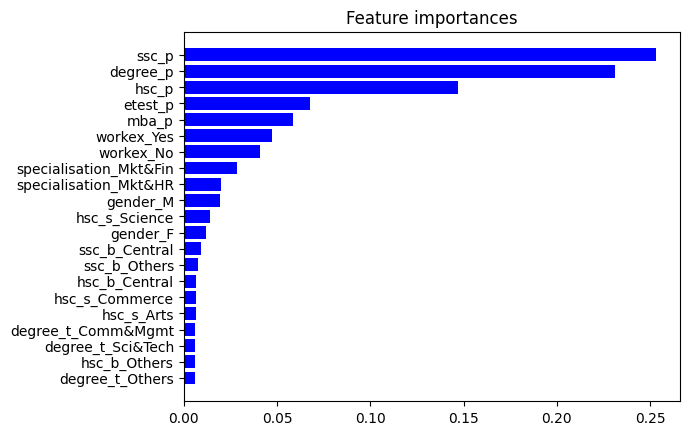

In [186]:
feature_importance = pipe["rf"].feature_importances_
feature_names = x_train_enc.columns

sorted_idx = feature_importance.argsort()

#Plot the feature importance
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], color='blue')
plt.title("Feature importances")
# plt.savefig("pictures/feat_imp1_depth_5.png")  # high quality
plt.show()


In [187]:
perm_imp_test = permutation_importance(pipe, x_test_enc, y_test, n_repeats=10, random_state=seed)

for i, feature in enumerate(x_test_enc.columns):
  print(f"- {feature} => Mean: {perm_imp_test.importances_mean[i]:.4f} ; Std: {perm_imp_test.importances_std[i]:.4f}")

- ssc_p => Mean: 0.0651 ; Std: 0.0474
- hsc_p => Mean: 0.0163 ; Std: 0.0256
- degree_p => Mean: -0.0209 ; Std: 0.0336
- etest_p => Mean: -0.0070 ; Std: 0.0276
- mba_p => Mean: 0.0558 ; Std: 0.0154
- gender_F => Mean: 0.0070 ; Std: 0.0182
- gender_M => Mean: 0.0186 ; Std: 0.0093
- ssc_b_Central => Mean: 0.0163 ; Std: 0.0107
- ssc_b_Others => Mean: 0.0163 ; Std: 0.0107
- hsc_b_Central => Mean: 0.0093 ; Std: 0.0114
- hsc_b_Others => Mean: -0.0023 ; Std: 0.0193
- hsc_s_Arts => Mean: 0.0000 ; Std: 0.0000
- hsc_s_Commerce => Mean: 0.0093 ; Std: 0.0114
- hsc_s_Science => Mean: 0.0070 ; Std: 0.0107
- degree_t_Comm&Mgmt => Mean: 0.0047 ; Std: 0.0140
- degree_t_Others => Mean: 0.0000 ; Std: 0.0000
- degree_t_Sci&Tech => Mean: 0.0023 ; Std: 0.0125
- workex_No => Mean: -0.0047 ; Std: 0.0250
- workex_Yes => Mean: -0.0302 ; Std: 0.0256
- specialisation_Mkt&Fin => Mean: -0.0023 ; Std: 0.0163
- specialisation_Mkt&HR => Mean: -0.0093 ; Std: 0.0114


In [188]:
perm_imp_train = permutation_importance(pipe, x_train_enc, y_train, n_repeats=10, random_state=seed)

for i, feature in enumerate(x_train_enc.columns):
  print(f"- {feature} => Mean: {perm_imp_test.importances_mean[i]:.4f} ; Std: {perm_imp_test.importances_std[i]:.4f}")

- ssc_p => Mean: 0.0651 ; Std: 0.0474
- hsc_p => Mean: 0.0163 ; Std: 0.0256
- degree_p => Mean: -0.0209 ; Std: 0.0336
- etest_p => Mean: -0.0070 ; Std: 0.0276
- mba_p => Mean: 0.0558 ; Std: 0.0154
- gender_F => Mean: 0.0070 ; Std: 0.0182
- gender_M => Mean: 0.0186 ; Std: 0.0093
- ssc_b_Central => Mean: 0.0163 ; Std: 0.0107
- ssc_b_Others => Mean: 0.0163 ; Std: 0.0107
- hsc_b_Central => Mean: 0.0093 ; Std: 0.0114
- hsc_b_Others => Mean: -0.0023 ; Std: 0.0193
- hsc_s_Arts => Mean: 0.0000 ; Std: 0.0000
- hsc_s_Commerce => Mean: 0.0093 ; Std: 0.0114
- hsc_s_Science => Mean: 0.0070 ; Std: 0.0107
- degree_t_Comm&Mgmt => Mean: 0.0047 ; Std: 0.0140
- degree_t_Others => Mean: 0.0000 ; Std: 0.0000
- degree_t_Sci&Tech => Mean: 0.0023 ; Std: 0.0125
- workex_No => Mean: -0.0047 ; Std: 0.0250
- workex_Yes => Mean: -0.0302 ; Std: 0.0256
- specialisation_Mkt&Fin => Mean: -0.0023 ; Std: 0.0163
- specialisation_Mkt&HR => Mean: -0.0093 ; Std: 0.0114


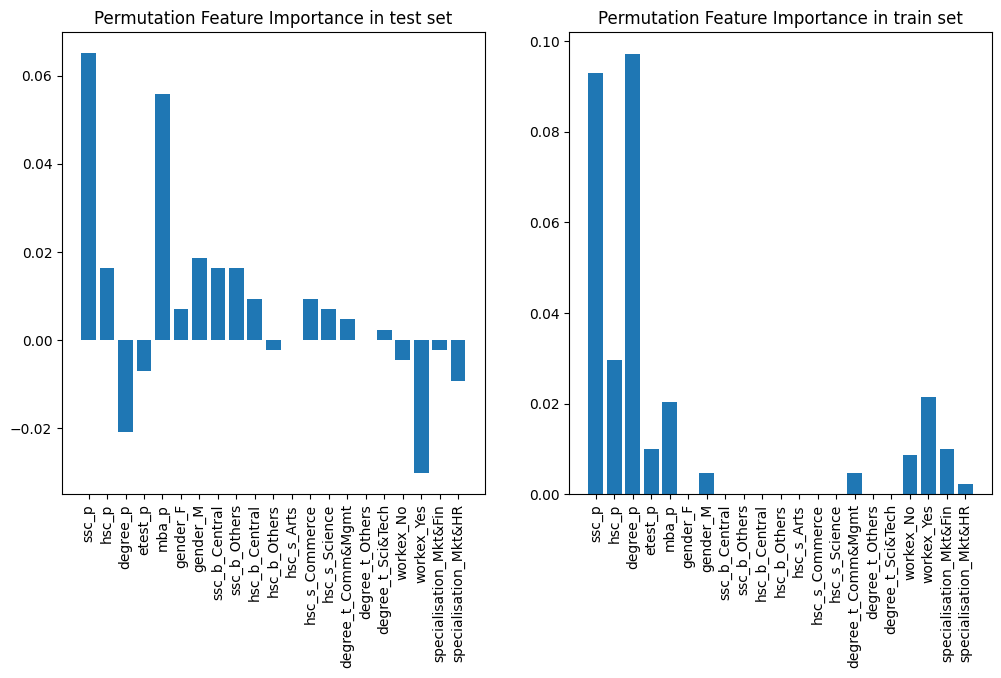

In [189]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(x_test_enc.shape[1]), perm_imp_test.importances_mean)
plt.xticks(range(x_test_enc.shape[1]), x_test_enc.columns, rotation=90)
plt.title("Permutation Feature Importance in test set")

plt.subplot(1, 2, 2)
plt.bar(range(x_train_enc.shape[1]), perm_imp_train.importances_mean)
plt.xticks(range(x_train_enc.shape[1]), x_train_enc.columns, rotation=90)
plt.title("Permutation Feature Importance in train set")

# plt.savefig("/pictures/pre_feat_imp2_depth_5.png", dpi=300, bbox_inches='tight')  # high quality

plt.show()

# Ranking

In [190]:
probs = pipe.predict_proba(x_test_enc)[:, 1]

In [191]:
ranking = probs.argsort()[::-1]
print(ranking)

[ 0  8  9 19 16  6 36 38 24 12  5 33 40 23 25 10 20 30 21 32 35 26 37 34
 31 11 29 15 42 39 22  7  2 18 41 27  1  4 17  3 28 14 13]


In [192]:
x_test.iloc[1]

gender                    M
ssc_p                  58.0
ssc_b                Others
hsc_p                  61.0
hsc_b                Others
hsc_s              Commerce
degree_p               61.0
degree_t          Comm&Mgmt
workex                   No
etest_p                58.0
specialisation       Mkt&HR
mba_p                 53.94
Name: 112, dtype: object

In [193]:
# Rank x and y accordingly
x_test_ranked = x_test.iloc[ranking].reset_index(drop=True)
y_test_ranked = y_test.iloc[ranking].reset_index(drop=True)
probs_ranked = probs[ranking]

In [194]:
# Select top 5
k = 10

x_topk = x_test_ranked.iloc[:k]
y_topk = y_test_ranked.iloc[:k]
probs_topk = probs_ranked[:k]

In [195]:
topk_df = x_topk.copy()
topk_df['true_label'] = y_topk
topk_df['pred_prob'] = probs_topk

print(topk_df)

  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p   degree_t  \
0      M  72.00   Others   63.0   Others   Science      77.5   Sci&Tech   
1      F  77.44  Central   92.0   Others  Commerce      72.0  Comm&Mgmt   
2      F  76.00  Central   70.0  Central   Science      76.0  Comm&Mgmt   
3      M  67.90   Others   62.0   Others   Science      67.0   Sci&Tech   
4      F  84.00   Others   75.0   Others   Science      69.0   Sci&Tech   
5      F  66.50  Central   66.8  Central      Arts      69.3  Comm&Mgmt   
6      M  73.00  Central   64.0   Others  Commerce      77.0  Comm&Mgmt   
7      F  72.00   Others   60.0   Others   Science      69.0  Comm&Mgmt   
8      M  83.00   Others   74.0   Others   Science      66.0  Comm&Mgmt   
9      F  78.00  Central   77.0   Others  Commerce      80.0  Comm&Mgmt   

  workex  etest_p specialisation  mba_p  true_label  pred_prob  
0    Yes    78.00        Mkt&Fin  54.48           1   0.955190  
1    Yes    94.00        Mkt&Fin  67.13     

# SHAP

In [196]:
id_instance_1 = 1
id_instance_2 = 24
class_instance = 1

sample = x_test_enc
masker = shap.maskers.Independent(data=x_test_enc)

explainer = shap.Explainer(model=pipe["rf"].predict_proba, # the function predict_proba
                           masker=masker)

shap_values = explainer.shap_values(sample)

shap_values_instance_1 = shap_values[id_instance_1][:, class_instance]
shap_values_instance_2 = shap_values[id_instance_2][:, class_instance]
print(shap_values_instance_1)
print()
print(shap_values_instance_2)

[-1.09520567e-01  3.60833584e-03 -1.51156017e-01  1.38988510e-03
  4.92275825e-02  5.42787493e-03  1.14699928e-02  1.00324192e-02
  1.82104842e-04  2.72151421e-04  3.07360469e-03 -1.22735691e-03
  3.68397815e-03  3.26896266e-03  2.90072894e-03  6.45383006e-05
  7.46591313e-04 -2.20852332e-02 -3.32660457e-02 -1.10887289e-02
 -4.81414185e-03]

[ 0.12638765  0.07469253  0.03015298 -0.00964767 -0.00970749  0.00887327
  0.01936226  0.00652073  0.00337834 -0.00015283  0.00866359 -0.0006074
 -0.00419185 -0.00487588  0.00229     0.00018222  0.00268846 -0.00942192
 -0.0136858  -0.01268265 -0.00709383]


In [197]:
shap_diff = np.subtract(shap_values_instance_1, shap_values_instance_2)
val_diff = np.subtract(x_test_enc.iloc[1], x_test_enc.iloc[24])

prod = shap_diff * val_diff

sum = np.sum(prod)
print(sum)

0.6905281165170476
